# Getting started

The goal of `simple` is to have a tiny [probablistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming) language compatible with some of the most common sampling libraries.
That way, it is easy to write a model (including all priors) for `emcee`, and then run it with `nautilus`, for example.

In this tutorial, we will do a short demo by sampling a 3D normal distribution.


In [1]:
import simple

print(simple.__version__)

0.1.dev39+g24fb30a.d20250618


## Model Definition

The two key components we need to specify in a Bayesian model are the prior distribution and the likelihood function.
Pretty much all sampling libraries require these two components, either separately for nested sampling, or combined in a posterior for MCMC.

In `simple`, the prior is specified as a dictionary of `Distribution` objects.
Most common distributions are already implemented in scipy, so the recommended approach, inspired by [nautilus](https://nautilus-sampler.readthedocs.io/en/latest/guides/priors.html), is to simply wrap scipy distributions whenever possible.

In [2]:
from scipy.stats import norm, uniform

from simple.distributions import ScipyDistribution

parameters = {
    "x1": ScipyDistribution(uniform, -5, 10),
    "x2": ScipyDistribution(uniform, 0, 10),
    "x3": ScipyDistribution(norm(0, 10)),
}
print("Priors:")
print(parameters)

Priors:
{'x1': ScipyDistribution(uniform(-5, 10)), 'x2': ScipyDistribution(uniform(0, 10)), 'x3': ScipyDistribution(norm(0, 10))}


Next, we need a log-likelihood function that takes a dictionary of parameters and computes the likelihood.
Here we don't have a dataset: we will just specify a distribution of three parameters directly.

In [3]:
from scipy.stats import multivariate_normal


def log_likelihood(params):
    """Log-likelihood function for a 3D normal distribution."""
    p = [params["x1"], params["x2"], params["x3"]]
    mean = [0.0, 3.0, 2.0]
    cov = [[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1.0]]
    return multivariate_normal.logpdf(p, mean=mean, cov=cov)

It is now time to create our `simple.Model` object.
The model needs to know what our priors and likelihood are.
It will then wrap them to provide:

- `log_prior(parameters)`: the prior distribution given a dictionary or an array of parameters
- `log_prob(parameters)`: the posterior distribution given a dictionary or an array of parameters
- `log_likelihood(parameters)`: a wrapper around our log-likelihood above to make it work with arrays and dictionaries
- `prior_transform(parameters)`: a prior transform from a unit hypercube to our parameter space

In [4]:
from simple.model import Model

model = Model(parameters, log_likelihood)

print(model)
test_point = [0, 1, 0]
print("Log-Prior", model.log_prior(test_point))
print("Log-Prior out of bounds", model.log_prior([-10, 3, 0]))
print("Log-likelihood", model.log_likelihood(test_point))
print("Log-posterior", model.log_prob(test_point))

Log-Prior -7.826693812186811
Log-Prior out of bounds -inf
Log-likelihood -7.279641230054793
Log-posterior -15.106335042241604


## Prior Checks

A good thing to do before fitting any model is to check the prior.
To sample directly from the prior, we can either pass a uniform distribution through the `prior_transform` function or sample the `log_prior()` function of our model with `emcee`.

Here, we will test both approaches.
In practice, it's probably a good idea to test your prior transform if you plan on using nested sampling and your log-prior if you plan on using MCMC.

### Via prior transform

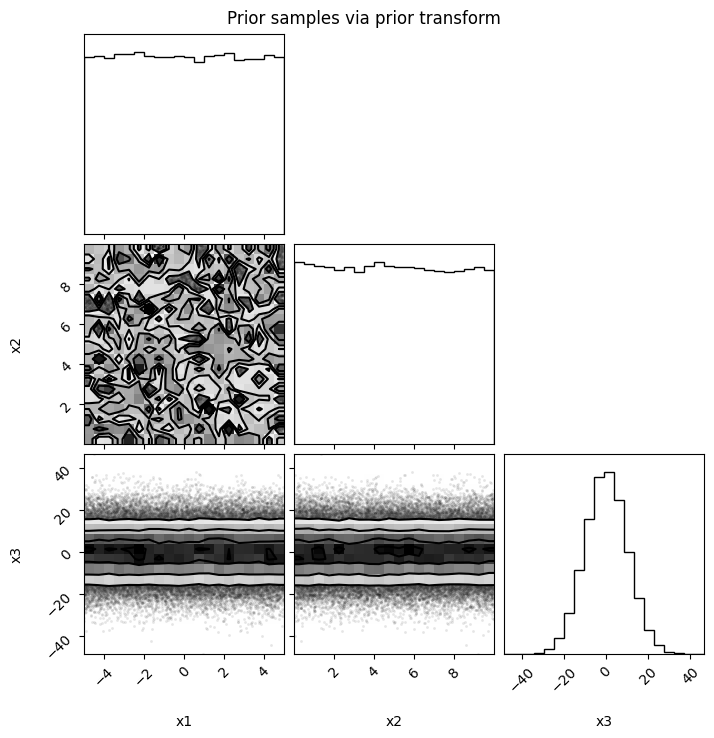

In [5]:
import corner
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng()
u = np.random.uniform(0, 1, size=(3, 100_000))
prior_samples = model.prior_transform(u)

fig = corner.corner(prior_samples.T, labels=model.keys())
fig.suptitle("Prior samples via prior transform")
plt.show()

### Via emcee

In [6]:
import emcee

sampler = emcee.EnsembleSampler(
    nwalkers=100,
    ndim=3,
    log_prob_fn=model.log_prior,
)

In [7]:
p0 = np.array(test_point) + 1e-4 * rng.standard_normal(size=(100, 3))
sampler.run_mcmc(p0, 1000, progress=True)

  0%|                                                                                                                                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]

  1%|█▋                                                                                                                                                                                                                                                                                    | 6/1000 [00:00<00:17, 57.43it/s]

  1%|███▎                                                                                                                                                                                                                                                                                 | 12/1000 [00:00<00:18, 54.21it/s]

  2%|████▉                                                                                                                                                                                                                                                                                | 18/1000 [00:00<00:18, 52.48it/s]

  2%|██████▋                                                                                                                                                                                                                                                                              | 24/1000 [00:00<00:19, 49.26it/s]

  3%|████████                                                                                                                                                                                                                                                                             | 29/1000 [00:00<00:20, 47.39it/s]

  3%|█████████▍                                                                                                                                                                                                                                                                           | 34/1000 [00:00<00:21, 45.95it/s]

  4%|██████████▊                                                                                                                                                                                                                                                                          | 39/1000 [00:00<00:21, 44.56it/s]

  4%|████████████▏                                                                                                                                                                                                                                                                        | 44/1000 [00:00<00:23, 40.01it/s]

  5%|█████████████▌                                                                                                                                                                                                                                                                       | 49/1000 [00:01<00:24, 38.90it/s]

  5%|██████████████▋                                                                                                                                                                                                                                                                      | 53/1000 [00:01<00:24, 39.11it/s]

  6%|████████████████                                                                                                                                                                                                                                                                     | 58/1000 [00:01<00:23, 40.75it/s]

  6%|█████████████████▍                                                                                                                                                                                                                                                                   | 63/1000 [00:01<00:21, 42.84it/s]

  7%|███████████████████                                                                                                                                                                                                                                                                  | 69/1000 [00:01<00:20, 45.44it/s]

  8%|████████████████████▊                                                                                                                                                                                                                                                                | 75/1000 [00:01<00:19, 47.87it/s]

  8%|██████████████████████▍                                                                                                                                                                                                                                                              | 81/1000 [00:01<00:18, 49.83it/s]

  9%|████████████████████████                                                                                                                                                                                                                                                             | 87/1000 [00:01<00:17, 51.82it/s]

  9%|█████████████████████████▊                                                                                                                                                                                                                                                           | 93/1000 [00:01<00:16, 53.61it/s]

 10%|███████████████████████████▍                                                                                                                                                                                                                                                         | 99/1000 [00:02<00:16, 54.38it/s]

 10%|████████████████████████████▉                                                                                                                                                                                                                                                       | 105/1000 [00:02<00:16, 55.34it/s]

 11%|██████████████████████████████▋                                                                                                                                                                                                                                                     | 111/1000 [00:02<00:15, 56.16it/s]

 12%|████████████████████████████████▎                                                                                                                                                                                                                                                   | 117/1000 [00:02<00:15, 57.12it/s]

 12%|██████████████████████████████████▏                                                                                                                                                                                                                                                 | 124/1000 [00:02<00:15, 58.26it/s]

 13%|████████████████████████████████████▏                                                                                                                                                                                                                                               | 131/1000 [00:02<00:14, 58.99it/s]

 14%|█████████████████████████████████████▊                                                                                                                                                                                                                                              | 137/1000 [00:02<00:14, 58.45it/s]

 14%|███████████████████████████████████████▍                                                                                                                                                                                                                                            | 143/1000 [00:02<00:14, 58.78it/s]

 15%|█████████████████████████████████████████                                                                                                                                                                                                                                           | 149/1000 [00:02<00:14, 58.15it/s]

 16%|██████████████████████████████████████████▊                                                                                                                                                                                                                                         | 155/1000 [00:03<00:14, 57.15it/s]

 16%|████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 161/1000 [00:03<00:14, 56.94it/s]

 17%|██████████████████████████████████████████████                                                                                                                                                                                                                                      | 167/1000 [00:03<00:14, 57.18it/s]

 17%|███████████████████████████████████████████████▋                                                                                                                                                                                                                                    | 173/1000 [00:03<00:14, 57.45it/s]

 18%|█████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 179/1000 [00:03<00:14, 57.36it/s]

 18%|███████████████████████████████████████████████████                                                                                                                                                                                                                                 | 185/1000 [00:03<00:14, 56.05it/s]

 19%|████████████████████████████████████████████████████▋                                                                                                                                                                                                                               | 191/1000 [00:03<00:14, 55.55it/s]

 20%|██████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 197/1000 [00:03<00:14, 55.53it/s]

 20%|████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 203/1000 [00:03<00:14, 55.03it/s]

 21%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                                          | 209/1000 [00:04<00:14, 54.09it/s]

 22%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 215/1000 [00:04<00:14, 53.76it/s]

 22%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                       | 221/1000 [00:04<00:14, 53.84it/s]

 23%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                     | 227/1000 [00:04<00:14, 54.53it/s]

 23%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 233/1000 [00:04<00:13, 55.40it/s]

 24%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                  | 239/1000 [00:04<00:13, 56.02it/s]

 24%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                | 245/1000 [00:04<00:13, 56.86it/s]

 25%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                              | 251/1000 [00:04<00:13, 53.96it/s]

 26%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                             | 257/1000 [00:04<00:14, 52.78it/s]

 26%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                           | 263/1000 [00:05<00:14, 52.55it/s]

 27%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 269/1000 [00:05<00:13, 52.33it/s]

 28%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                        | 275/1000 [00:05<00:14, 50.93it/s]

 28%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                      | 281/1000 [00:05<00:14, 49.04it/s]

 29%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                     | 286/1000 [00:05<00:14, 48.22it/s]

 29%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 291/1000 [00:05<00:14, 47.65it/s]

 30%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                  | 296/1000 [00:05<00:14, 47.16it/s]

 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                 | 301/1000 [00:05<00:15, 46.32it/s]

 31%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                               | 306/1000 [00:05<00:15, 43.55it/s]

 31%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                              | 311/1000 [00:06<00:16, 41.26it/s]

 32%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 316/1000 [00:06<00:17, 38.74it/s]

 32%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 320/1000 [00:06<00:18, 36.13it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                          | 324/1000 [00:06<00:19, 34.55it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                         | 328/1000 [00:06<00:21, 31.00it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                        | 332/1000 [00:06<00:21, 31.28it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 336/1000 [00:06<00:20, 33.00it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 340/1000 [00:07<00:19, 34.17it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 345/1000 [00:07<00:17, 37.01it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 350/1000 [00:07<00:16, 38.74it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 355/1000 [00:07<00:16, 39.43it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                | 360/1000 [00:07<00:15, 41.14it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 365/1000 [00:07<00:15, 41.07it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 370/1000 [00:07<00:15, 41.00it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 375/1000 [00:07<00:14, 41.86it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 380/1000 [00:07<00:15, 41.25it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 385/1000 [00:08<00:15, 39.30it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 390/1000 [00:08<00:14, 40.91it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 395/1000 [00:08<00:14, 42.96it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 401/1000 [00:08<00:13, 45.58it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 407/1000 [00:08<00:12, 47.87it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 413/1000 [00:08<00:11, 50.07it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 419/1000 [00:08<00:11, 51.81it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 425/1000 [00:08<00:10, 53.38it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 431/1000 [00:08<00:10, 54.77it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 437/1000 [00:09<00:10, 55.41it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 443/1000 [00:09<00:10, 52.20it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 449/1000 [00:09<00:10, 52.07it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 455/1000 [00:09<00:10, 52.61it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 461/1000 [00:09<00:10, 53.59it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 467/1000 [00:09<00:09, 54.73it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 473/1000 [00:09<00:09, 55.11it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 479/1000 [00:09<00:09, 55.82it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 485/1000 [00:09<00:09, 56.23it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 491/1000 [00:10<00:08, 56.82it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 498/1000 [00:10<00:08, 58.38it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 504/1000 [00:10<00:08, 57.78it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 510/1000 [00:10<00:08, 57.16it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 516/1000 [00:10<00:08, 57.03it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 522/1000 [00:10<00:08, 57.20it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 528/1000 [00:10<00:08, 55.94it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 534/1000 [00:10<00:08, 52.32it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 540/1000 [00:10<00:09, 50.58it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 546/1000 [00:11<00:08, 50.64it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 552/1000 [00:11<00:08, 50.11it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 558/1000 [00:11<00:08, 49.82it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 564/1000 [00:11<00:08, 50.17it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 570/1000 [00:11<00:08, 50.15it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 576/1000 [00:11<00:08, 49.38it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 581/1000 [00:11<00:08, 49.50it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 586/1000 [00:11<00:08, 49.07it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 591/1000 [00:12<00:08, 47.06it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 596/1000 [00:12<00:08, 45.43it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 601/1000 [00:12<00:09, 43.21it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 606/1000 [00:12<00:09, 40.80it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 611/1000 [00:12<00:09, 39.22it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 615/1000 [00:12<00:09, 39.28it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 619/1000 [00:12<00:09, 38.45it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 623/1000 [00:12<00:10, 36.23it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 627/1000 [00:12<00:10, 36.52it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 632/1000 [00:13<00:09, 37.77it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 637/1000 [00:13<00:09, 38.73it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 642/1000 [00:13<00:08, 39.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 647/1000 [00:13<00:08, 42.23it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 653/1000 [00:13<00:07, 45.04it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 659/1000 [00:13<00:07, 47.43it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 665/1000 [00:13<00:06, 48.98it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 671/1000 [00:13<00:06, 51.15it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 677/1000 [00:14<00:06, 53.03it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 683/1000 [00:14<00:05, 54.51it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 690/1000 [00:14<00:05, 56.31it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 696/1000 [00:14<00:05, 56.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 702/1000 [00:14<00:05, 57.40it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 709/1000 [00:14<00:04, 58.26it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 716/1000 [00:14<00:04, 59.11it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 722/1000 [00:14<00:04, 58.64it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 728/1000 [00:14<00:04, 58.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 734/1000 [00:14<00:04, 58.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 741/1000 [00:15<00:04, 59.27it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 748/1000 [00:15<00:04, 59.66it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 755/1000 [00:15<00:04, 59.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 762/1000 [00:15<00:03, 60.34it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 769/1000 [00:15<00:03, 60.01it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 775/1000 [00:15<00:03, 59.96it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 782/1000 [00:15<00:03, 60.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 789/1000 [00:15<00:03, 60.33it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 796/1000 [00:15<00:03, 60.51it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 803/1000 [00:16<00:03, 59.91it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 809/1000 [00:16<00:03, 59.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 816/1000 [00:16<00:03, 60.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 823/1000 [00:16<00:03, 58.92it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 829/1000 [00:16<00:03, 56.56it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 835/1000 [00:16<00:02, 56.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 841/1000 [00:16<00:02, 55.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 847/1000 [00:16<00:02, 54.35it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 853/1000 [00:17<00:02, 54.09it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 859/1000 [00:17<00:02, 51.71it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 865/1000 [00:17<00:02, 50.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 871/1000 [00:17<00:02, 51.23it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 877/1000 [00:17<00:02, 50.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 883/1000 [00:17<00:02, 51.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 889/1000 [00:17<00:02, 50.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 895/1000 [00:17<00:02, 51.25it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 901/1000 [00:17<00:01, 51.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 907/1000 [00:18<00:01, 51.21it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 913/1000 [00:18<00:01, 48.46it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 918/1000 [00:18<00:01, 44.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 923/1000 [00:18<00:01, 42.65it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 928/1000 [00:18<00:01, 38.74it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 933/1000 [00:18<00:01, 39.32it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 938/1000 [00:18<00:01, 40.48it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 943/1000 [00:18<00:01, 42.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 948/1000 [00:19<00:01, 43.38it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 953/1000 [00:19<00:01, 43.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 958/1000 [00:19<00:00, 43.70it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 963/1000 [00:19<00:00, 44.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 968/1000 [00:19<00:00, 44.25it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 973/1000 [00:19<00:00, 44.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 979/1000 [00:19<00:00, 48.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 985/1000 [00:19<00:00, 50.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 992/1000 [00:19<00:00, 54.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 998/1000 [00:20<00:00, 54.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.66it/s]

State([[-1.61267240e+00  4.85656863e+00 -7.74872950e+00]
 [ 1.36942032e+00  2.29650397e+00  1.93070122e+00]
 [ 4.87012705e+00  6.15924712e+00 -1.94594483e+01]
 [ 3.54940729e+00  5.90176799e+00 -1.94152601e+01]
 [-4.87588355e+00  5.17544536e+00  1.40754709e-01]
 [-1.32960850e+00  6.48942405e+00 -2.47485980e+00]
 [ 3.96083880e+00  2.56262974e+00 -1.78718834e+01]
 [ 1.01478701e+00  9.67190495e-01  5.86365834e-01]
 [ 8.95635640e-02  8.60057746e+00 -1.22410483e+01]
 [ 3.40325263e+00  9.59766847e+00  6.53532262e+00]
 [-2.87355667e+00  5.31868838e+00  1.96624955e+01]
 [ 1.19084886e+00  5.34151973e+00 -3.28613025e+00]
 [-4.29366608e+00  9.59446499e-01 -7.60210882e+00]
 [ 3.62557348e+00  7.25181637e+00 -1.18188175e+01]
 [-6.85801158e-01  8.10763923e+00 -3.27766270e+00]
 [-3.37851002e+00  3.27080523e+00 -1.44965306e+01]
 [ 2.20934319e+00  5.96998166e-01 -5.86792275e+00]
 [ 3.55694192e+00  8.50780513e+00  1.55505391e+01]
 [-3.88258923e+00  3.57322742e+00 -7.39916751e+00]
 [ 2.24579207e-01  4.1185

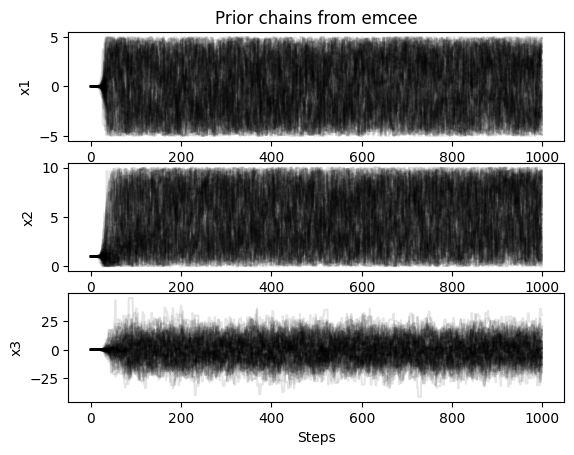

In [8]:
chains = sampler.get_chain()

fig, axs = plt.subplots(3, 1)
for i in range(3):
    axs[i].plot(chains[:, :, i], "k-", alpha=0.1)
    axs[i].set_ylabel(model.keys()[i])
axs[-1].set_xlabel("Steps")
axs[0].set_title("Prior chains from emcee")
plt.show()

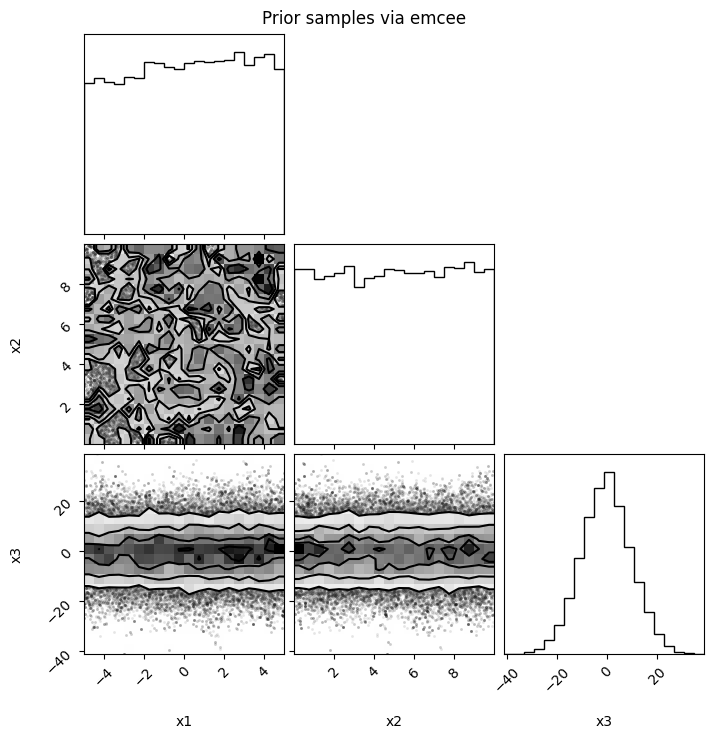

In [9]:
flat_chains = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(flat_chains, labels=model.keys())
fig.suptitle("Prior samples via emcee")
plt.show()

## Sampling with `emcee`

We can now sample the posterior with emcee. We can basically copy the previous subsection, but replace `log_prior` with `log_prob` in our sampler definition.

In [10]:
import emcee

sampler = emcee.EnsembleSampler(
    nwalkers=100,
    ndim=3,
    log_prob_fn=model.log_prob,
)

In [11]:
p0 = np.array(test_point) + 1e-4 * rng.standard_normal(size=(100, 3))
sampler.run_mcmc(p0, 1000, progress=True)

  0%|                                                                                                                                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]

  0%|█                                                                                                                                                                                                                                                                                     | 4/1000 [00:00<00:27, 35.92it/s]

  1%|██▏                                                                                                                                                                                                                                                                                   | 8/1000 [00:00<00:27, 35.61it/s]

  1%|███▎                                                                                                                                                                                                                                                                                 | 12/1000 [00:00<00:27, 35.35it/s]

  2%|████▍                                                                                                                                                                                                                                                                                | 16/1000 [00:00<00:27, 35.31it/s]

  2%|█████▌                                                                                                                                                                                                                                                                               | 20/1000 [00:00<00:27, 35.48it/s]

  2%|██████▋                                                                                                                                                                                                                                                                              | 24/1000 [00:00<00:27, 35.49it/s]

  3%|███████▊                                                                                                                                                                                                                                                                             | 28/1000 [00:00<00:27, 35.61it/s]

  3%|████████▊                                                                                                                                                                                                                                                                            | 32/1000 [00:00<00:27, 35.83it/s]

  4%|█████████▉                                                                                                                                                                                                                                                                           | 36/1000 [00:01<00:26, 36.12it/s]

  4%|███████████                                                                                                                                                                                                                                                                          | 40/1000 [00:01<00:26, 36.12it/s]

  4%|████████████▏                                                                                                                                                                                                                                                                        | 44/1000 [00:01<00:26, 36.30it/s]

  5%|█████████████▎                                                                                                                                                                                                                                                                       | 48/1000 [00:01<00:26, 36.49it/s]

  5%|██████████████▍                                                                                                                                                                                                                                                                      | 52/1000 [00:01<00:25, 36.50it/s]

  6%|███████████████▌                                                                                                                                                                                                                                                                     | 56/1000 [00:01<00:25, 36.37it/s]

  6%|████████████████▌                                                                                                                                                                                                                                                                    | 60/1000 [00:01<00:26, 35.90it/s]

  6%|█████████████████▋                                                                                                                                                                                                                                                                   | 64/1000 [00:01<00:26, 35.82it/s]

  7%|██████████████████▊                                                                                                                                                                                                                                                                  | 68/1000 [00:01<00:26, 35.82it/s]

  7%|███████████████████▉                                                                                                                                                                                                                                                                 | 72/1000 [00:02<00:25, 35.89it/s]

  8%|█████████████████████                                                                                                                                                                                                                                                                | 76/1000 [00:02<00:25, 35.84it/s]

  8%|██████████████████████▏                                                                                                                                                                                                                                                              | 80/1000 [00:02<00:25, 35.90it/s]

  8%|███████████████████████▎                                                                                                                                                                                                                                                             | 84/1000 [00:02<00:25, 35.79it/s]

  9%|████████████████████████▍                                                                                                                                                                                                                                                            | 88/1000 [00:02<00:25, 35.30it/s]

  9%|█████████████████████████▍                                                                                                                                                                                                                                                           | 92/1000 [00:02<00:25, 35.43it/s]

 10%|██████████████████████████▌                                                                                                                                                                                                                                                          | 96/1000 [00:02<00:25, 35.66it/s]

 10%|███████████████████████████▌                                                                                                                                                                                                                                                        | 100/1000 [00:02<00:25, 35.56it/s]

 10%|████████████████████████████▋                                                                                                                                                                                                                                                       | 104/1000 [00:02<00:25, 35.60it/s]

 11%|█████████████████████████████▊                                                                                                                                                                                                                                                      | 108/1000 [00:03<00:24, 36.14it/s]

 11%|██████████████████████████████▉                                                                                                                                                                                                                                                     | 112/1000 [00:03<00:24, 36.29it/s]

 12%|████████████████████████████████                                                                                                                                                                                                                                                    | 116/1000 [00:03<00:24, 36.18it/s]

 12%|█████████████████████████████████                                                                                                                                                                                                                                                   | 120/1000 [00:03<00:24, 36.11it/s]

 12%|██████████████████████████████████▏                                                                                                                                                                                                                                                 | 124/1000 [00:03<00:24, 36.00it/s]

 13%|███████████████████████████████████▎                                                                                                                                                                                                                                                | 128/1000 [00:03<00:24, 35.83it/s]

 13%|████████████████████████████████████▍                                                                                                                                                                                                                                               | 132/1000 [00:03<00:24, 36.09it/s]

 14%|█████████████████████████████████████▌                                                                                                                                                                                                                                              | 136/1000 [00:03<00:24, 35.86it/s]

 14%|██████████████████████████████████████▋                                                                                                                                                                                                                                             | 140/1000 [00:03<00:23, 36.01it/s]

 14%|███████████████████████████████████████▋                                                                                                                                                                                                                                            | 144/1000 [00:04<00:23, 36.24it/s]

 15%|████████████████████████████████████████▊                                                                                                                                                                                                                                           | 148/1000 [00:04<00:23, 36.08it/s]

 15%|█████████████████████████████████████████▉                                                                                                                                                                                                                                          | 152/1000 [00:04<00:23, 36.08it/s]

 16%|███████████████████████████████████████████                                                                                                                                                                                                                                         | 156/1000 [00:04<00:23, 36.25it/s]

 16%|████████████████████████████████████████████▏                                                                                                                                                                                                                                       | 160/1000 [00:04<00:23, 36.27it/s]

 16%|█████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 164/1000 [00:04<00:23, 36.34it/s]

 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                     | 168/1000 [00:04<00:22, 36.28it/s]

 17%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                    | 172/1000 [00:04<00:22, 36.19it/s]

 18%|████████████████████████████████████████████████▌                                                                                                                                                                                                                                   | 176/1000 [00:04<00:22, 36.34it/s]

 18%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                  | 180/1000 [00:05<00:22, 36.28it/s]

 18%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                 | 184/1000 [00:05<00:22, 36.28it/s]

 19%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                | 188/1000 [00:05<00:22, 36.43it/s]

 19%|████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 192/1000 [00:05<00:22, 36.24it/s]

 20%|██████████████████████████████████████████████████████                                                                                                                                                                                                                              | 196/1000 [00:05<00:22, 36.20it/s]

 20%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 200/1000 [00:05<00:22, 36.34it/s]

 20%|████████████████████████████████████████████████████████▎                                                                                                                                                                                                                           | 204/1000 [00:05<00:21, 36.44it/s]

 21%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                                                          | 208/1000 [00:05<00:21, 36.16it/s]

 21%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                                                         | 212/1000 [00:05<00:21, 35.97it/s]

 22%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                        | 216/1000 [00:05<00:21, 36.17it/s]

 22%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 220/1000 [00:06<00:21, 36.35it/s]

 22%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 224/1000 [00:06<00:21, 36.43it/s]

 23%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 228/1000 [00:06<00:21, 36.51it/s]

 23%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                    | 232/1000 [00:06<00:21, 36.41it/s]

 24%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 236/1000 [00:06<00:20, 36.45it/s]

 24%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                 | 240/1000 [00:06<00:20, 36.52it/s]

 24%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 244/1000 [00:06<00:20, 36.53it/s]

 25%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                               | 248/1000 [00:06<00:20, 36.42it/s]

 25%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                              | 252/1000 [00:06<00:20, 36.44it/s]

 26%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                             | 256/1000 [00:07<00:20, 36.12it/s]

 26%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                            | 260/1000 [00:07<00:20, 36.27it/s]

 26%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 264/1000 [00:07<00:20, 36.43it/s]

 27%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 268/1000 [00:07<00:20, 36.45it/s]

 27%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 272/1000 [00:07<00:20, 35.78it/s]

 28%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                       | 276/1000 [00:07<00:20, 35.71it/s]

 28%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 280/1000 [00:07<00:20, 35.94it/s]

 28%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 284/1000 [00:07<00:19, 35.94it/s]

 29%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 288/1000 [00:07<00:19, 36.12it/s]

 29%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 292/1000 [00:08<00:19, 36.19it/s]

 30%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                  | 296/1000 [00:08<00:19, 36.28it/s]

 30%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 300/1000 [00:08<00:19, 36.11it/s]

 30%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                | 304/1000 [00:08<00:19, 36.24it/s]

 31%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/1000 [00:08<00:19, 36.31it/s]

 31%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 312/1000 [00:08<00:18, 36.48it/s]

 32%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 316/1000 [00:08<00:18, 36.44it/s]

 32%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 320/1000 [00:08<00:18, 36.33it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                          | 324/1000 [00:08<00:18, 36.24it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                         | 328/1000 [00:09<00:18, 36.29it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                        | 332/1000 [00:09<00:18, 36.22it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 336/1000 [00:09<00:18, 36.33it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 340/1000 [00:09<00:18, 36.34it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 344/1000 [00:09<00:18, 36.05it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 348/1000 [00:09<00:18, 36.12it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 352/1000 [00:09<00:17, 36.18it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 356/1000 [00:09<00:17, 36.19it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                | 360/1000 [00:09<00:17, 36.16it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 364/1000 [00:10<00:17, 36.03it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 368/1000 [00:10<00:17, 36.18it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 372/1000 [00:10<00:17, 36.20it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 376/1000 [00:10<00:17, 36.18it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 380/1000 [00:10<00:17, 36.35it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 384/1000 [00:10<00:17, 36.08it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                         | 388/1000 [00:10<00:16, 36.12it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 392/1000 [00:10<00:16, 36.19it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 396/1000 [00:10<00:16, 36.20it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 400/1000 [00:11<00:16, 36.17it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 404/1000 [00:11<00:16, 36.21it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 408/1000 [00:11<00:16, 35.90it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 412/1000 [00:11<00:16, 35.96it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 416/1000 [00:11<00:16, 35.65it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 420/1000 [00:11<00:16, 35.90it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 424/1000 [00:11<00:15, 36.09it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 428/1000 [00:11<00:15, 36.14it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 432/1000 [00:11<00:15, 36.05it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 436/1000 [00:12<00:15, 36.17it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 440/1000 [00:12<00:15, 36.05it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 444/1000 [00:12<00:15, 36.21it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 448/1000 [00:12<00:15, 36.28it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 452/1000 [00:12<00:15, 36.17it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 456/1000 [00:12<00:14, 36.27it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 460/1000 [00:12<00:14, 36.50it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 464/1000 [00:12<00:14, 36.59it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 468/1000 [00:12<00:14, 36.46it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 472/1000 [00:13<00:14, 36.31it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 476/1000 [00:13<00:14, 36.24it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 480/1000 [00:13<00:14, 36.35it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 484/1000 [00:13<00:14, 36.27it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 488/1000 [00:13<00:14, 36.18it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 492/1000 [00:13<00:13, 36.32it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 496/1000 [00:13<00:13, 36.34it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 500/1000 [00:13<00:13, 36.29it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 504/1000 [00:13<00:13, 36.16it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 508/1000 [00:14<00:13, 36.19it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 512/1000 [00:14<00:13, 36.30it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 516/1000 [00:14<00:13, 36.12it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 520/1000 [00:14<00:13, 36.15it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 524/1000 [00:14<00:13, 36.20it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 528/1000 [00:14<00:13, 36.24it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 532/1000 [00:14<00:13, 35.98it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 536/1000 [00:14<00:13, 35.31it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 540/1000 [00:14<00:13, 35.05it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 544/1000 [00:15<00:13, 34.90it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 548/1000 [00:15<00:12, 34.78it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 552/1000 [00:15<00:13, 34.33it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 556/1000 [00:15<00:12, 34.21it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 560/1000 [00:15<00:12, 34.06it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 564/1000 [00:15<00:12, 34.34it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 568/1000 [00:15<00:12, 34.42it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 572/1000 [00:15<00:12, 34.29it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 576/1000 [00:16<00:12, 34.43it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 580/1000 [00:16<00:12, 34.52it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 584/1000 [00:16<00:12, 34.66it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 588/1000 [00:16<00:11, 34.80it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 592/1000 [00:16<00:11, 34.92it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 596/1000 [00:16<00:11, 35.01it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 600/1000 [00:16<00:11, 35.01it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 604/1000 [00:16<00:11, 35.13it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 608/1000 [00:16<00:11, 35.19it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 612/1000 [00:17<00:10, 35.29it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 616/1000 [00:17<00:11, 34.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 620/1000 [00:17<00:10, 34.72it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 624/1000 [00:17<00:10, 34.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 628/1000 [00:17<00:10, 34.81it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 632/1000 [00:17<00:10, 33.79it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 636/1000 [00:17<00:10, 34.04it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 640/1000 [00:17<00:10, 34.25it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 644/1000 [00:17<00:10, 34.45it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 648/1000 [00:18<00:10, 34.76it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 652/1000 [00:18<00:10, 34.62it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 656/1000 [00:18<00:09, 34.66it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 660/1000 [00:18<00:09, 34.66it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 664/1000 [00:18<00:09, 34.76it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 668/1000 [00:18<00:09, 34.85it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 672/1000 [00:18<00:09, 34.84it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 676/1000 [00:18<00:09, 34.93it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 680/1000 [00:18<00:09, 34.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 684/1000 [00:19<00:09, 34.75it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 688/1000 [00:19<00:08, 34.73it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 692/1000 [00:19<00:08, 34.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 696/1000 [00:19<00:08, 34.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 700/1000 [00:19<00:08, 34.62it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 704/1000 [00:19<00:08, 34.68it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 708/1000 [00:19<00:08, 34.64it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 712/1000 [00:19<00:08, 34.66it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 716/1000 [00:20<00:08, 34.77it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 720/1000 [00:20<00:08, 34.69it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 724/1000 [00:20<00:07, 34.81it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 728/1000 [00:20<00:07, 34.70it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 732/1000 [00:20<00:07, 34.82it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 736/1000 [00:20<00:07, 34.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 740/1000 [00:20<00:07, 34.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 744/1000 [00:20<00:07, 34.75it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 748/1000 [00:20<00:07, 34.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 752/1000 [00:21<00:07, 34.74it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 756/1000 [00:21<00:07, 34.59it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 760/1000 [00:21<00:06, 34.84it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 764/1000 [00:21<00:06, 34.77it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 768/1000 [00:21<00:06, 34.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 772/1000 [00:21<00:06, 34.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 776/1000 [00:21<00:06, 34.79it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 780/1000 [00:21<00:06, 34.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 784/1000 [00:21<00:06, 34.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 788/1000 [00:22<00:06, 34.92it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 792/1000 [00:22<00:05, 34.97it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 796/1000 [00:22<00:05, 34.97it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 800/1000 [00:22<00:05, 35.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 804/1000 [00:22<00:05, 35.03it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 808/1000 [00:22<00:05, 34.98it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 812/1000 [00:22<00:05, 35.04it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 816/1000 [00:22<00:05, 35.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 820/1000 [00:23<00:05, 34.98it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 824/1000 [00:23<00:05, 35.00it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 828/1000 [00:23<00:04, 34.95it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 832/1000 [00:23<00:04, 34.93it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 836/1000 [00:23<00:04, 34.99it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 840/1000 [00:23<00:04, 35.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 844/1000 [00:23<00:04, 35.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 848/1000 [00:23<00:04, 35.13it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 852/1000 [00:23<00:04, 35.00it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 856/1000 [00:24<00:04, 35.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 860/1000 [00:24<00:03, 35.12it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 864/1000 [00:24<00:03, 35.18it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 868/1000 [00:24<00:03, 35.15it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 872/1000 [00:24<00:03, 35.15it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 876/1000 [00:24<00:03, 35.14it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 880/1000 [00:24<00:03, 35.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 884/1000 [00:24<00:03, 35.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 888/1000 [00:24<00:03, 35.11it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 892/1000 [00:25<00:03, 35.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 896/1000 [00:25<00:02, 35.15it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 900/1000 [00:25<00:02, 35.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 904/1000 [00:25<00:02, 35.12it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 908/1000 [00:25<00:02, 35.13it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 912/1000 [00:25<00:02, 34.93it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 916/1000 [00:25<00:02, 34.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 920/1000 [00:25<00:02, 34.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 924/1000 [00:25<00:02, 34.69it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 928/1000 [00:26<00:02, 34.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 932/1000 [00:26<00:01, 34.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 936/1000 [00:26<00:01, 34.94it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 940/1000 [00:26<00:01, 34.93it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 944/1000 [00:26<00:01, 35.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 948/1000 [00:26<00:01, 34.99it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 952/1000 [00:26<00:01, 34.90it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 956/1000 [00:26<00:01, 34.95it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 960/1000 [00:27<00:01, 34.94it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 964/1000 [00:27<00:01, 34.99it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 968/1000 [00:27<00:00, 34.95it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 972/1000 [00:27<00:00, 34.80it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 976/1000 [00:27<00:00, 34.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 980/1000 [00:27<00:00, 34.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 984/1000 [00:27<00:00, 34.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 988/1000 [00:27<00:00, 34.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 992/1000 [00:27<00:00, 34.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 996/1000 [00:28<00:00, 34.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.50it/s]

State([[ 1.64507188  3.44322885  1.65090806]
 [-0.6650063   3.65191258  1.60927929]
 [ 1.01668077  5.73644866  2.21681589]
 [ 0.76230117  3.62582519  2.96484274]
 [-2.30970624  1.63103974  2.74024063]
 [ 0.05682767  4.47289182  0.69806547]
 [ 1.81708277  4.60597616  0.93460789]
 [ 1.17560065  3.49652018  3.15783044]
 [ 0.55811407  5.16882688  2.6209421 ]
 [-1.26570263  2.18063371  3.12847459]
 [ 0.89874113  3.74379197  0.00855472]
 [ 0.24114022  2.94650402  1.9161501 ]
 [-0.58372065  4.59437022  0.54828514]
 [-0.94000687  2.77651618  3.87990542]
 [ 0.91591104  3.19167405  1.91944487]
 [ 0.49898654  2.36524163  1.92838519]
 [-0.59432449  4.94944066  2.33673581]
 [-2.49829353  2.41511738  1.53307154]
 [ 2.22837057  5.63021724  1.95289056]
 [-0.30776618  3.55379928  2.58725558]
 [ 0.5154173   1.90401049  1.75237707]
 [-0.97807352  2.53036287  2.42175256]
 [ 0.27492553  3.32271223  0.53173879]
 [ 1.35753877  3.24721173  0.61408553]
 [-1.22085792  2.29423463  2.68127213]
 [ 0.58302609  2.59

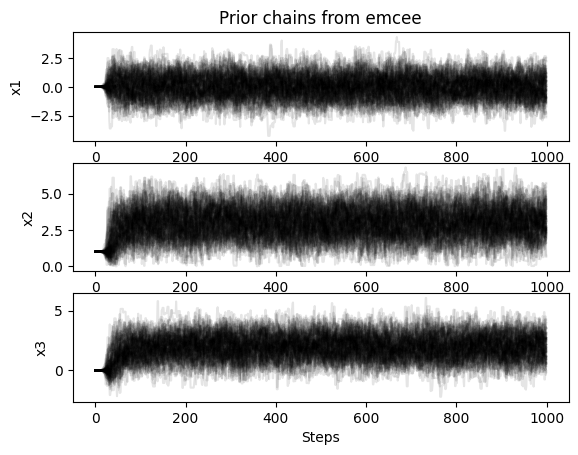

In [12]:
chains = sampler.get_chain()

fig, axs = plt.subplots(3, 1)
for i in range(3):
    axs[i].plot(chains[:, :, i], "k-", alpha=0.1)
    axs[i].set_ylabel(model.keys()[i])
axs[-1].set_xlabel("Steps")
axs[0].set_title("Prior chains from emcee")
plt.show()

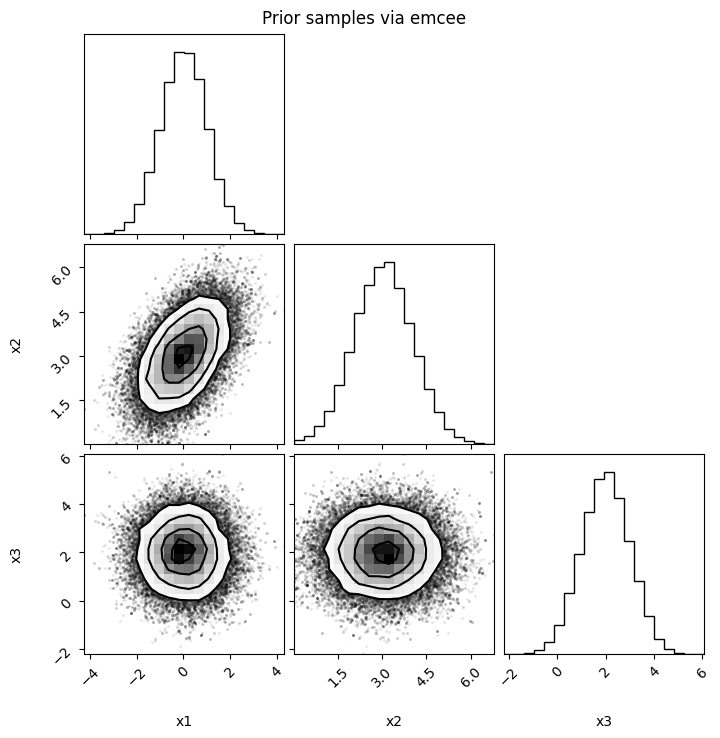

In [13]:
flat_chains = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(flat_chains, labels=model.keys())
fig.suptitle("Prior samples via emcee")
plt.show()

## Sampling with `ultranest`

Next, let us try and sample the model with Ultranest.

In [14]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(
    model.keys(), model.log_likelihood, model.prior_transform
)

result = sampler.run(show_status=False)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3  


[ultranest] Likelihood function evaluations: 6174


[ultranest]   logZ = -7.757 +- 0.06843


[ultranest] Effective samples strategy satisfied (ESS = 1896.5, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)


[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.01 total:0.07 required:<0.50


[ultranest] done iterating.


In [15]:
sampler.print_results()


logZ = -7.740 +- 0.113
  single instance: logZ = -7.740 +- 0.095
  bootstrapped   : logZ = -7.757 +- 0.113
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    x1                  : -4.0  │ ▁▁▁▁▁▁▁▁▁▂▂▃▃▅▄▅▆▇▇▆▆▆▄▅▄▂▂▂▁▁▁▁▁▁  ▁ │3.9       -0.0 +- 1.0
    x2                  : 0.0   │ ▁▁▁▁▁▂▃▂▄▄▆▆▇▇▇▇▇▆▇▆▅▄▄▂▂▂▂▁▁▁▁▁ ▁ ▁▁ │7.2       3.0 +- 1.0
    x3                  : -1.87 │ ▁ ▁▁▁▁▁▁▁▂▂▃▄▅▅▆▇▆▇▇▇▆▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁ │5.82      1.96 +- 0.99



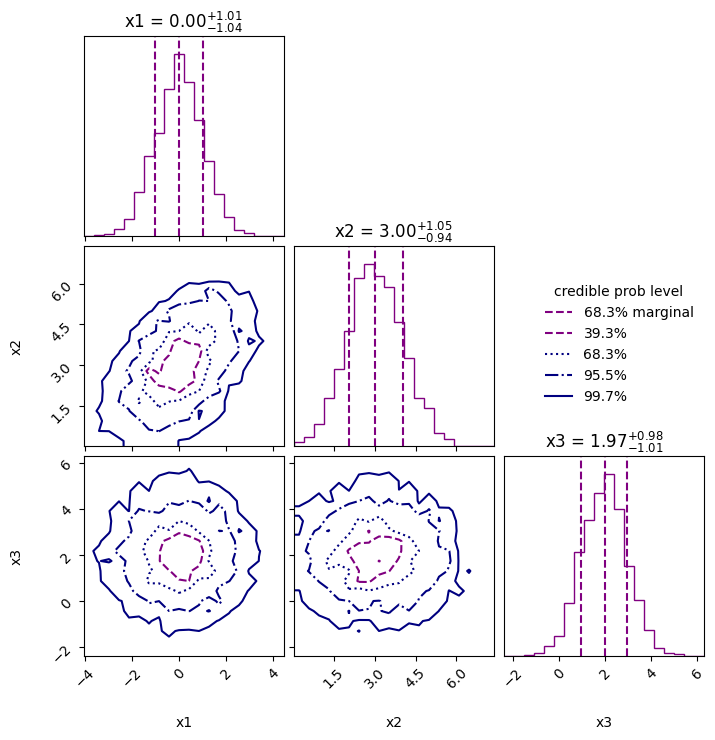

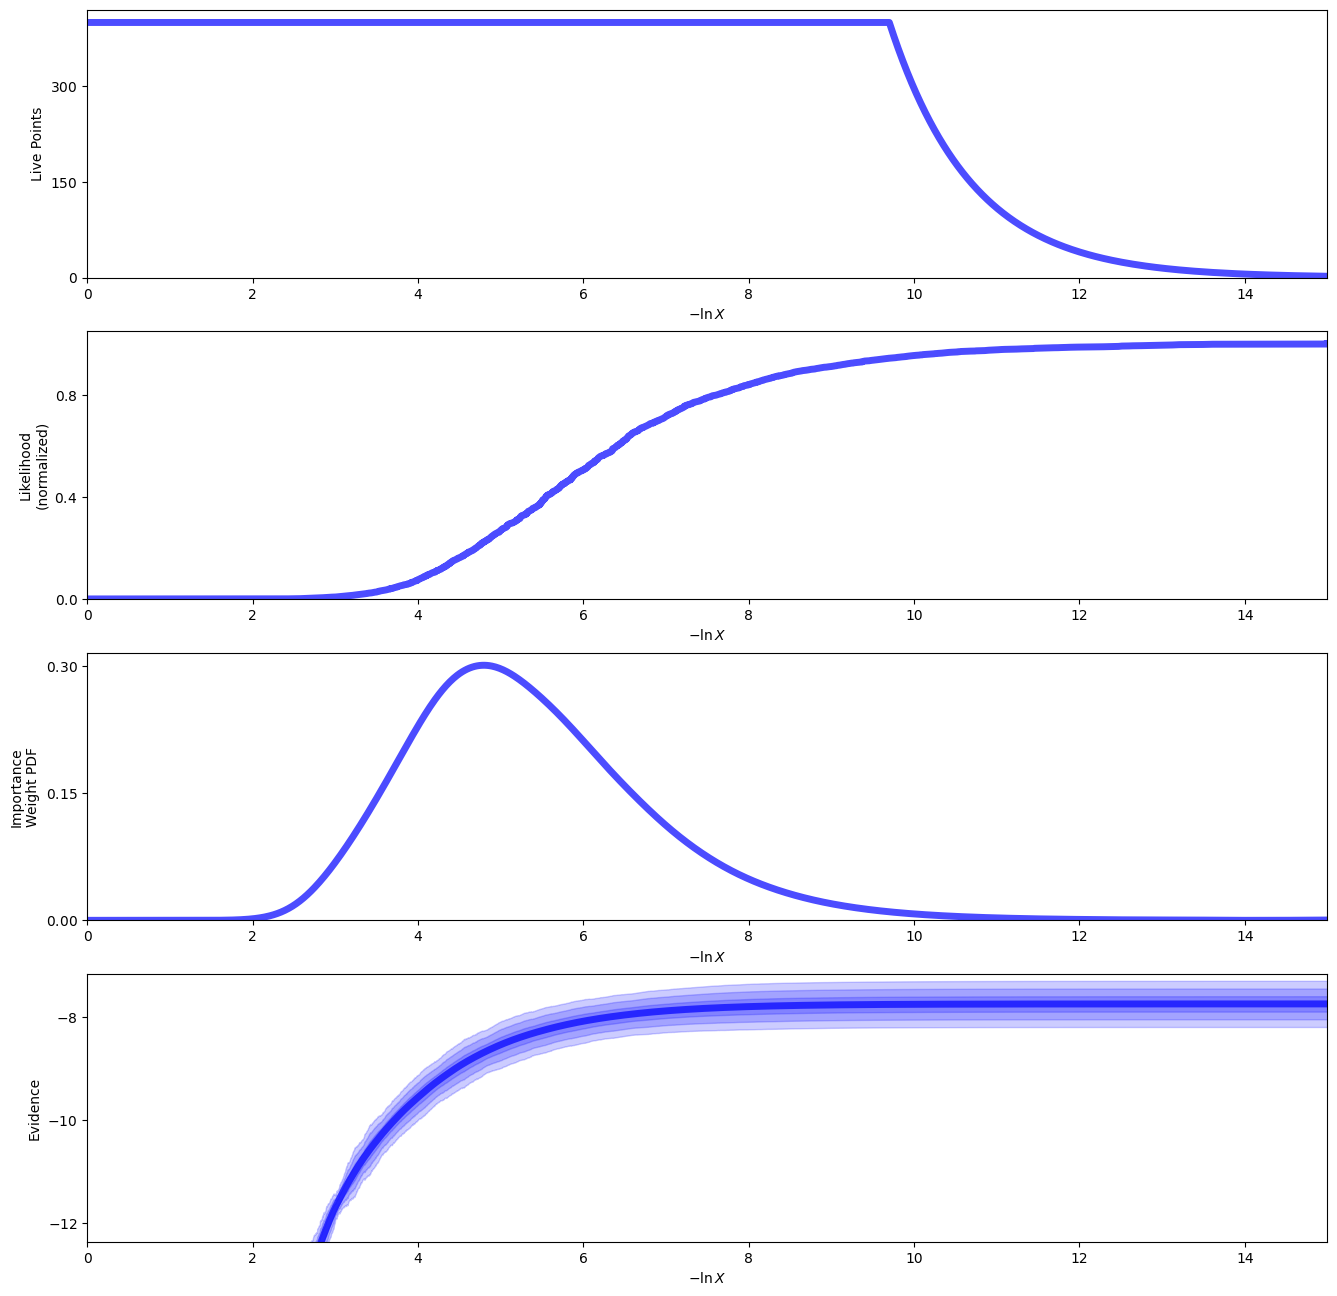

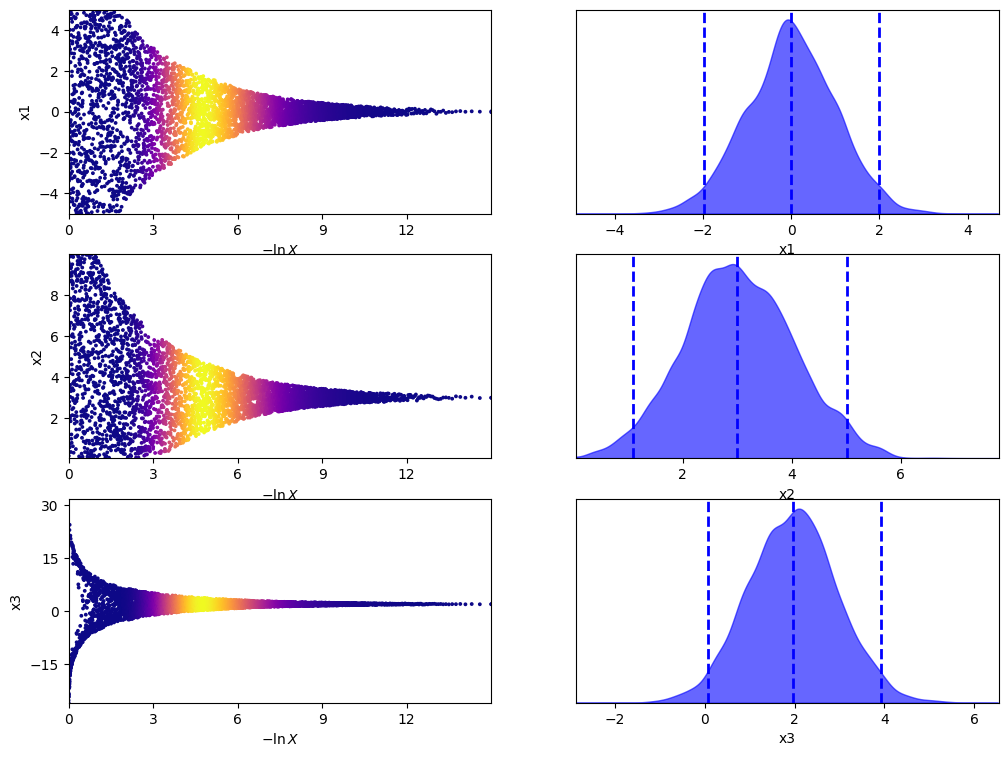

In [16]:
sampler.plot_corner()
plt.show()
sampler.plot_run()
plt.show()
sampler.plot_trace()
plt.show()

## Sampling with `nautilus`

In [17]:
from nautilus import Sampler

sampler = Sampler(model.nautilus_prior(), model.log_likelihood, n_live=1000)
sampler.run(verbose=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    


Finished  | 14     | 1        | 4        | 17800    | N/A    | 10021 | -7.87    


np.True_

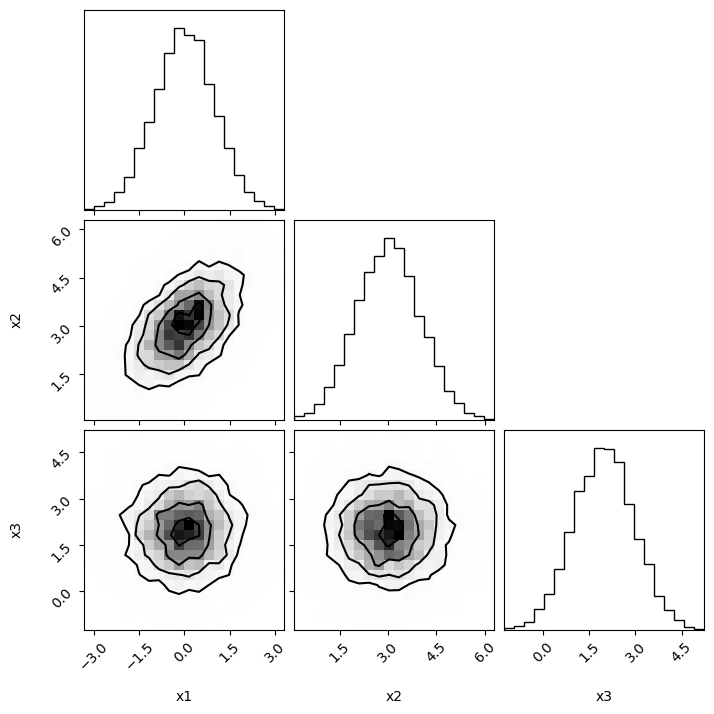

In [18]:
points, log_w, log_l = sampler.posterior()
corner.corner(
    points,
    weights=np.exp(log_w),
    labels=model.keys(),
    plot_datapoints=False,
    range=np.repeat(0.999, len(model.parameters)),
)
plt.show()

## Comparison

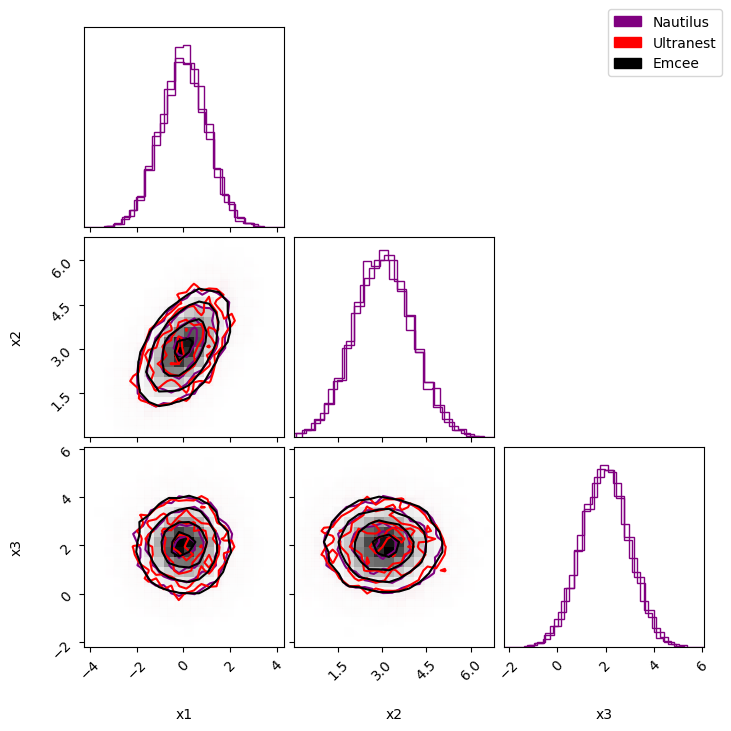

In [19]:
from matplotlib import patches

hist_kwargs = dict(density=True)

fig = corner.corner(
    points,
    weights=np.exp(log_w),
    labels=model.keys(),
    color="purple",
    hist_kwargs=hist_kwargs,
    plot_datapoints=False,
    range=np.repeat(0.999, len(model.parameters)),
)
data = np.array(result["weighted_samples"]["points"])
weights = np.array(result["weighted_samples"]["weights"])
corner.corner(
    data,
    weights=weights,
    color="red",
    hist_kwargs=hist_kwargs,
    plot_datapoints=False,
    range=np.repeat(0.999, len(model.parameters)),
    fig=fig,
)
corner.corner(
    flat_chains,
    weights=np.ones(flat_chains.shape[0]),
    color="k",
    hist_kwargs=hist_kwargs,
    plot_datapoints=False,
    fig=fig,
)


nautilus_patch = patches.Patch(color="purple", label="Nautilus")
ultranest_patch = patches.Patch(color="red", label="Ultranest")
emcee_patch = patches.Patch(color="k", label="Emcee")

fig.legend(
    handles=[nautilus_patch, ultranest_patch, emcee_patch],
    loc="upper right",  # You can also use 'upper left', 'lower right', etc.
    bbox_to_anchor=(0.98, 0.98),
)

plt.show()